In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
#dados das eleições dos anos de 2006 e 2010
data = pd.read_csv("../data/train.csv")

#removendo variáveis irrelevantes
data = data.drop(columns=['sequencial_candidato', 'nome'])

#selecionando atributos numéricos
numeric_feats = data.dtypes[data.dtypes != "object"].index

#normalizando variáveis numéricas exceto ano
data[numeric_feats[1:]] = np.log1p(data[numeric_feats[1:]])

#dummy das variáveis categoricas
X_train = data.drop(columns=['situacao'])
X_train = pd.get_dummies(X_train)
#dumy da variável alvo, eleito = 1 e nao_eleito = 0
Y_train = data.situacao
Y_train = Y_train.replace(['nao_eleito', 'eleito'], [0, 1])

In [ ]:
#plotando distribuição da variável alvo
sns.countplot(Y_train)            

As classes estão claramente desbalanceadas, essa diferença pode enviesar a aprendizagem do modelo.Isso pode ser tratrado por meio de técnicas de `Under-sampling`.

In [3]:
#Função para calcular o AUC-Precision&Recall na validação cruzada
from sklearn.model_selection import cross_val_score
def f1_cv(model, X, Y):
    f1 = cross_val_score(model, X, Y, scoring='f1', cv=5)
    return(f1)

### Regressão Logistíca

In [ ]:
from sklearn.linear_model import LogisticRegression
lambdas = np.arange(0.01,2,0.01).tolist()

cv_logRegression = [f1_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1)).mean()
                    for lbd in lambdas]
cv_logRegression = pd.Series(cv_logRegression, index = lambdas)

In [ ]:
import matplotlib.pyplot as plt
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

### KNN

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
neighbors = np.arange(1,100,1).tolist()
cv_knn = [f1_cv(KNeighborsClassifier(n_neighbors=neighbor)).mean() 
            for neighbor in neighbors]
cv_knn = pd.Series(cv_knn, index = neighbors)

#plot do AUC-Precision&Recall na validação cruzada
cv_knn.plot(title = "Cross validation - KNN")
plt.xlabel("Neighbor")
plt.ylabel("F1-score")
print("A melhor quantidade de vizinhos é {0}, com F1 = {1}".format(cv_knn.idxmax(), cv_knn.max()))

### Decision Tree

In [ ]:
from sklearn import tree
depths = np.arange(1,15,1).tolist()
cv_tree = [f1_cv(tree.DecisionTreeClassifier(max_depth = depth)).mean() 
            for depth in depths]
cv_tree = pd.Series(cv_tree, index = depths)

#plot do AUC-Precision&Recall na validação cruzada
cv_tree.plot(title = "Cross validation - Decision Tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")
print("A profundidade ideal é {0}, com F1 = {1}".format(cv_tree.idxmax(), cv_tree.max()))

Neste caso é claro o viés causado pelo desbalanceamento das classes, a melhor profundidade 

### Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
estimators = np.arange(1,50,1).tolist()
cv_ada =  [f1_cv(AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), 
                                    algorithm="SAMME", 
                                    n_estimators=estimator)).mean() 
            for estimator in estimators]
cv_ada = pd.Series(cv_ada, index = estimators)

#plot do AUC-Precision&Recall na validação cruzada
cv_ada.plot(title = "Cross validation - Adaboost")
plt.xlabel("Estimator")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))


# Competição Kaggle

Para resolver o problema do desbalanceamento entre as classe vou utilizar a técnica de under-sampling NearMiss version 1, que pioriza a fronteira de decisão entre as classes. Deste modo é esperado que os modelos tenham um desempenho melhor, já que não sofrem mais com o viés da classe majoritária.

/home/diogo/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


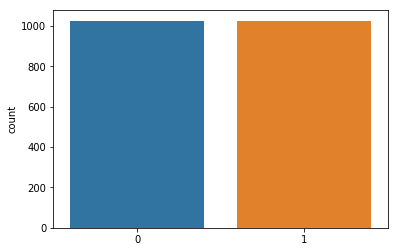

In [7]:
#balanceando as classes
from imblearn.under_sampling import NearMiss
nm = NearMiss(version=1)
X_train_balanced, Y_train_balanced = nm.fit_resample(X_train, Y_train)
#plotando distribuição da variável alvo
sns.countplot(Y_train_balanced)

### Logistic Regression

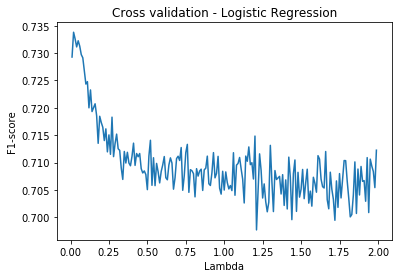

O melhor alpha é 0.02, com F1 = 0.733810142922


In [8]:
from sklearn.linear_model import LogisticRegression
lambdas = np.arange(0.01,2,0.01).tolist()
cv_logRegression = [f1_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1), 
                          X_train_balanced, Y_train_balanced).mean()
                    for lbd in lambdas]
cv_logRegression = pd.Series(cv_logRegression, index = lambdas)

#plot do AUC-Precision&Recall na validação cruzada
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

In [24]:
m = LogisticRegression(solver="lbfgs", max_iter=10000, C=0.02, random_state=1)
m.fit(X_train_balanced, Y_train_balanced)
from sklearn import metrics
print(metrics.classification_report(Y_train, m.predict(X_train), output_dict=True)["macro avg"]["f1-score"])

0.828386841476


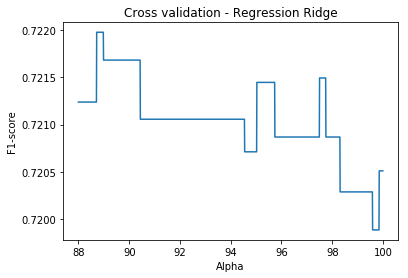

O melhor alpha é 88.72, com F1 = 0.721977505821


In [21]:
from sklearn.linear_model import RidgeClassifier
alphas = np.arange(88,100,0.01).tolist()
cv_ridge = [f1_cv(RidgeClassifier(alpha = alpha), 
                          X_train_balanced, Y_train_balanced).mean()
                    for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)

#plot do AUC-Precision&Recall na validação cruzada
cv_ridge.plot(title = "Cross validation - Regression Ridge")
plt.xlabel("Alpha")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_ridge.idxmax(), cv_ridge.max()))

In [23]:
m = RidgeClassifier(alpha = 88.72)
m.fit(X_train_balanced, Y_train_balanced)
from sklearn import metrics
print(metrics.classification_report(Y_train, m.predict(X_train), output_dict=True)["macro avg"]["f1-score"])

0.847787746934


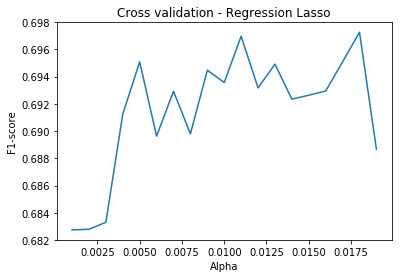

O melhor alpha é 0.018, com F1 = 0.69725734461


In [36]:
from sklearn import ensemble

alphas = np.arange(0.001,0.02,0.001).tolist()
cv_gb = [f1_cv(ensemble.GradientBoostingClassifier(learning_rate=alpha), 
                          X_train_balanced, Y_train_balanced).mean()
                    for alpha in alphas]
cv_gb = pd.Series(cv_gb, index = alphas)

#plot do AUC-Precision&Recall na validação cruzada
cv_gb.plot(title = "Cross validation - Regression Lasso")
plt.xlabel("Alpha")
plt.ylabel("F1-score")
plt.show()
print("O melhor alpha é {0}, com F1 = {1}".format(cv_gb.idxmax(), cv_gb.max()))

### KNN

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
neighbors = np.arange(1,50,1).tolist()
cv_knn = [f1_cv(KNeighborsClassifier(n_neighbors=neighbor)).mean() 
            for neighbor in neighbors]
cv_knn = pd.Series(cv_knn, index = neighbors)

#plot do AUC-Precision&Recall na validação cruzada
cv_knn.plot(title = "Cross validation - KNN")
plt.xlabel("Neighbor")
plt.ylabel("F1-score")
print("A melhor quantidade de vizinhos é {0}, com F1 = {1}".format(cv_knn.idxmax(), cv_knn.max()))

### Decision Tree

In [ ]:
from sklearn import tree
depths = np.arange(1,15,1).tolist()
cv_tree = [f1_cv(tree.DecisionTreeClassifier(max_depth = depth)).mean() 
            for depth in depths]
cv_tree = pd.Series(cv_tree, index = depths)

#plot do AUC-Precision&Recall na validação cruzada
cv_tree.plot(title = "Cross validation - Decision Tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")
print("A profundidade ideal é {0}, com F1 = {1}".format(cv_tree.idxmax(), cv_tree.max()))

### Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
estimators = np.arange(1,50,1).tolist()
cv_ada =  [f1_cv(AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), 
                                    algorithm="SAMME", 
                                    n_estimators=estimator)).mean() 
            for estimator in estimators]
cv_ada = pd.Series(cv_ada, index = estimators)

#plot do AUC-Precision&Recall na validação cruzada
cv_ada.plot(title = "Cross validation - Adaboost")
plt.xlabel("Estimator")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
trees = np.arange(1,15,1).tolist()
cv_random_forest = [f1_cv(RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)).mean() 
                    for trees in trees]
cv_random_forest = pd.Series(cv_random_forest, index = trees)

#plot do AUC-Precision&Recall na validação cruzada
cv_random_forest.plot(title = "Cross validation - Random Forest")
plt.xlabel("Tree")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_random_forest.idxmax(), cv_random_forest.max()))

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
estimators = np.arange(1,50,1).tolist()
cv_gb =  [f1_cv(GradientBoostingClassifier(n_estimators=estimator, learning_rate=1.0,
                 max_depth=1, random_state=0)).mean() 
            for estimator in estimators]
cv_gb = pd.Series(cv_gb, index = estimators)

#plot do AUC-Precision&Recall na validação cruzada
cv_gb.plot(title = "Cross validation - Adaboost")
plt.xlabel("Estimator")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_gb.idxmax(), cv_gb.max()))

### Submission

In [6]:
data = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

#variavel alvo
Y_train = data.situacao
data.drop(columns=['situacao'])

data = pd.concat((data,test))

#removendo variáveis irrelevantes
data = data.drop(columns=['sequencial_candidato', 'nome'])

#selecionando atributos numéricos
numeric_feats = data.dtypes[data.dtypes != "object"].index

#normalizando variáveis numéricas exceto ano
data[numeric_feats[1:]] = np.log1p(data[numeric_feats[1:]])

#dummy das variáveis categoricas
data = pd.get_dummies(data)

X_train = data.loc[data['ano'] != 2014]
test = data.loc[data['ano'] == 2014]

from sklearn.linear_model import LogisticRegression
m = LogisticRegression(solver="lbfgs", max_iter=10000, C=0.03, random_state=1)
m.fit(X_train, Y_train)
predict = m.predict(test)
predict = pd.DataFrame(predict)
predict.to_csv("submission_sample", sep='\t', encoding='utf-8')

/home/diogo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  
